In [ ]:
"""Visualize 3D convolution outputs for QC and inspection."""

Thi document runs visualizations outputting `.mp4` and `.gif` files of 3D organoid data.
This notebok runs nviz to create the visualizations and napari.

## Imports

In [ ]:
import argparse
import os
import pathlib
import shutil
import sys

import numpy as np
import pandas as pd
import skimage.io as io
import tifffile
from image_analysis_3D.file_utils.arg_parsing_utils import (
    check_for_missing_args,
    parse_args,
)
from image_analysis_3D.file_utils.notebook_init_utils import (
    bandicoot_check,
    init_notebook,
)
from moviepy.editor import VideoFileClip
from napari.utils import nbscreenshot
from napari_animation import Animation
from napari_animation.easing import Easing
from nviz.image import image_set_to_arrays
from nviz.image_meta import extract_z_slice_number_from_filename, generate_ome_xml
from nviz.view import view_ometiff_with_napari
from PIL import Image

root_dir, in_notebook = init_notebook()

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)

In [2]:
def mp4_to_gif(input_mp4, output_gif, fps=10):
    clip = VideoFileClip(input_mp4)
    clip = clip.set_fps(fps)  # Reduce FPS to control file size
    clip.write_gif(output_gif, loop=0)  # loop=0 makes it loop forever


def animate_view(
    viewer, output_path_name: str, steps: int = 30, easing: str = "linear", dim: int = 3
):
    animation = Animation(viewer)
    if easing == "linear":
        ease_style = Easing.LINEAR
    else:
        raise ValueError(f"Invalid easing style: {easing}")

    viewer.dims.ndisplay = dim
    # rotate around the y-axis
    viewer.camera.angles = (0.0, 0.0, 90.0)  # (z, y, x) axis of rotation
    animation.capture_keyframe(steps=steps, ease=ease_style)

    viewer.camera.angles = (0.0, 180.0, 90.0)
    animation.capture_keyframe(steps=steps, ease=ease_style)

    viewer.camera.angles = (0.0, 360.0, 90.0)
    animation.capture_keyframe(steps=steps, ease=ease_style)

    viewer.camera.angles = (0.0, 0.0, 270.0)
    animation.capture_keyframe(steps=steps, ease=ease_style)

    viewer.camera.angles = (0.0, 0.0, 90.0)
    animation.capture_keyframe(steps=steps, ease=ease_style)

    animation.animate(output_path_name, canvas_only=True)

In [3]:
if not in_notebook:
    args = parse_args()
    well_fov = args["well_fov"]
    patient = args["patient"]
    input_subparent_name = args["input_subparent_name"]
    mask_subparent_name = args["mask_subparent_name"]
    animation_subparent_name = args["animation_subparent_name"]
    check_for_missing_args(
        well_fov=well_fov,
        patient=patient,
        input_subparent_name=input_subparent_name,
        mask_subparent_name=mask_subparent_name,
        animation_subparent_name=animation_subparent_name,
    )
else:
    print("Running in a notebook")
    patient = "NF0014_T1"
    well_fov = "C4-2"
    input_subparent_name = "convolution_25"
    mask_subparent_name = "convolution_25_segmentation_masks"
    animation_subparent_name = "convolution_25"

image_dir = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{input_subparent_name}/{well_fov}/"
).resolve(strict=True)
masks_dir = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{mask_subparent_name}/{well_fov}/"
).resolve(strict=True)

mp4_file_dir = pathlib.Path(
    f"{root_dir}/0.preprocessing_data/animations/{animation_subparent_name}/mp4/{well_fov}/"
).resolve()
gif_file_dir = pathlib.Path(
    f"{root_dir}/0.preprocessing_data/animations/{animation_subparent_name}/gif/{well_fov}/"
).resolve()

mp4_file_dir.mkdir(parents=True, exist_ok=True)
gif_file_dir.mkdir(parents=True, exist_ok=True)

Running in a notebook


In [4]:
label_dir = image_dir
output_path = "output.zarr"
channel_map = {
    "405": "Nuclei",
    "488": "Endoplasmic Reticulum",
    "555": "Actin, Golgi, and plasma membrane (AGP)",
    "640": "Mitochondria",
    "TRANS": "Brightfield",
}
scaling_values = [1, 0.1, 0.1]

In [ ]:
# write a temp dir containing all images
temporary_dir = pathlib.Path("temp_viz_dir")
if temporary_dir.exists():
    shutil.rmtree(temporary_dir)
temporary_dir.mkdir(exist_ok=True)
for image in image_dir.glob("*"):
    print(image)
    image_name = image.stem
    temp_image_path = temporary_dir / f"{image_name}.tif"
    shutil.copyfile(image, temp_image_path)

/home/lippincm/mnt/bandicoot/NF1_organoid_data/data/NF0014_T1/convolution_25/C4-2/nuclei_masks.tiff
/home/lippincm/mnt/bandicoot/NF1_organoid_data/data/NF0014_T1/convolution_25/C4-2/organoid_masks.tiff
/home/lippincm/mnt/bandicoot/NF1_organoid_data/data/NF0014_T1/convolution_25/C4-2/C4-2_640.tif
/home/lippincm/mnt/bandicoot/NF1_organoid_data/data/NF0014_T1/convolution_25/C4-2/cell_masks.tiff
/home/lippincm/mnt/bandicoot/NF1_organoid_data/data/NF0014_T1/convolution_25/C4-2/C4-2_555.tif
/home/lippincm/mnt/bandicoot/NF1_organoid_data/data/NF0014_T1/convolution_25/C4-2/C4-2_488.tif
/home/lippincm/mnt/bandicoot/NF1_organoid_data/data/NF0014_T1/convolution_25/C4-2/cytoplasm_masks.tiff
/home/lippincm/mnt/bandicoot/NF1_organoid_data/data/NF0014_T1/convolution_25/C4-2/C4-2_405.tif


In [6]:
label_dir = image_dir
frame_zstacks = image_set_to_arrays(
    temporary_dir,
    temporary_dir,
    channel_map=channel_map,
)

images_data = []
labels_data = []
channel_names = []
label_names = []


for channel, stack in frame_zstacks["images"].items():
    print(f"Processing channel: {channel} with shape {stack.shape}")
    dim = len(stack.shape)
    images_data.append(stack)
    channel_names.append(channel)

# Collect label data
if label_dir:
    for compartment_name, stack in frame_zstacks["labels"].items():
        if "mask" not in compartment_name:
            continue
        if len(stack.shape) != dim:
            if len(stack.shape) == 3:
                stack = np.expand_dims(stack, axis=0)
        labels_data.append(stack)
        label_names.append(f"{compartment_name} (labels)")


# Stack the images and labels along a new axis for channels
images_data = np.stack(images_data, axis=0)
if labels_data:
    labels_data = np.stack(labels_data, axis=0)
    combined_data = np.concatenate((images_data, labels_data), axis=0)
    combined_channel_names = channel_names + label_names
else:
    combined_data = images_data
    combined_channel_names = channel_names
# Generate OME-XML metadata
ome_metadata = {
    "SizeC": combined_data.shape[0],
    "SizeZ": combined_data.shape[1],
    "SizeY": combined_data.shape[2],
    "SizeX": combined_data.shape[3],
    "PhysicalSizeX": scaling_values[2],
    "PhysicalSizeY": scaling_values[1],
    "PhysicalSizeZ": scaling_values[0],
    # note: we use 7-bit ascii compatible characters below
    # due to tifffile limitations
    "PhysicalSizeXUnit": "um",
    "PhysicalSizeYUnit": "um",
    "PhysicalSizeZUnit": "um",
    "Channel": [{"Name": name} for name in combined_channel_names],
}
ome_xml = generate_ome_xml(ome_metadata)

# Write the combined data to a single OME-TIFF
with tifffile.TiffWriter(output_path, bigtiff=True) as tif:
    tif.write(combined_data, description=ome_xml, photometric="minisblack")

Processing channel: C4-2_405 with shape (1, 33, 1537, 1540)
Processing channel: C4-2_488 with shape (1, 33, 1537, 1540)
Processing channel: C4-2_555 with shape (1, 33, 1537, 1540)
Processing channel: C4-2_640 with shape (1, 33, 1537, 1540)
Processing channel: cell_masks with shape (1, 33, 1537, 1540)
Processing channel: cytoplasm_masks with shape (1, 33, 1537, 1540)
Processing channel: nuclei_masks with shape (1, 33, 1537, 1540)
Processing channel: organoid_masks with shape (1, 33, 1537, 1540)


In [7]:
shutil.rmtree(temporary_dir)

In [8]:
viewer = view_ometiff_with_napari(
    ometiff_path=output_path,
    scaling_values=scaling_values,
    headless=False,
)

In [9]:
# get the layer names in the viewer
layer_names = [layer.name for layer in viewer.layers]
# set all layers to not visible
for layer_name in layer_names:
    print(f"Setting {layer_name} to not visible")
viewer.layers[layer_name].visible = True

Setting C4-2_405 to not visible
Setting C4-2_488 to not visible
Setting C4-2_555 to not visible
Setting C4-2_640 to not visible
Setting cell_masks to not visible
Setting cytoplasm_masks to not visible
Setting nuclei_masks to not visible
Setting organoid_masks to not visible
Setting cell_masks (labels) to not visible
Setting cytoplasm_masks (labels) to not visible
Setting nuclei_masks (labels) to not visible
Setting organoid_masks (labels) to not visible


In [10]:
viewer.layers[layer_name].visible = True

In [11]:
# make the viewer full screen
viewer.window._qt_window.showMaximized()
# hide the layer controls
viewer.window._qt_viewer.dockLayerList.setVisible(False)
# hide the layer controls
viewer.window._qt_viewer.dockLayerControls.setVisible(False)
# set the viewer to a set window size
viewer.window._qt_window.resize(1000, 1000)

# get the layer names in the viewer
layer_names = [layer.name for layer in viewer.layers]
# set all layers to not visible
for layer_name in layer_names:
    print(f"Setting {layer_name} to not visible")
    viewer.layers[layer_name].visible = False
for layer_name in layer_names:
    viewer.layers[layer_name].visible = True
    if ".tif" in layer_name:
        save_name = layer_name.split(".tif")[0]
    else:
        save_name = layer_name
    # map the layer name to the channel name
    if "Nuclei" in layer_name:
        save_name = "DNA"
    elif "Endoplasmic" in layer_name:
        save_name = "ER"
    elif "AGP" in layer_name:
        save_name = "AGP"
    elif "Mitochondria" in layer_name:
        save_name = "mitochondria"
    elif "Brightfield" in layer_name:
        save_name = "brightfield"
    else:
        save_name = layer_name
    print(f"Animating layer: {layer_name} saving to {save_name}")

    save_path = pathlib.Path(f"{mp4_file_dir}/{well_fov}_{save_name}_animation.mp4")
    if "640" in layer_name:
        # increase contrast for the mitochondria
        viewer.layers[layer_name].contrast_limits = (0, 20000)
    animate_view(viewer, save_path, steps=30, easing="linear")
    viewer.layers[layer_name].visible = False
print("All layers animated")
# get all gifs in the directory
mp4_file_path = list(pathlib.Path(mp4_file_dir).rglob("*.mp4"))
for mp4_file in mp4_file_path:
    # change the path to the gif directory
    mp4_file = pathlib.Path(mp4_file)
    gif_file = pathlib.Path(gif_file_dir / f"{mp4_file.stem}.gif")
    mp4_file = str(mp4_file)
    gif_file = str(gif_file)
    mp4_to_gif(mp4_file, gif_file)

Setting C4-2_405 to not visible
Setting C4-2_488 to not visible
Setting C4-2_555 to not visible
Setting C4-2_640 to not visible
Setting cell_masks to not visible
Setting cytoplasm_masks to not visible
Setting nuclei_masks to not visible
Setting organoid_masks to not visible
Setting cell_masks (labels) to not visible
Setting cytoplasm_masks (labels) to not visible
Setting nuclei_masks (labels) to not visible
Setting organoid_masks (labels) to not visible
Animating layer: C4-2_405 saving to C4-2_405
Rendering frames...


100%|██████████| 121/121 [00:03<00:00, 32.02it/s]


Animating layer: C4-2_488 saving to C4-2_488
Rendering frames...


100%|██████████| 121/121 [00:03<00:00, 31.91it/s]


Animating layer: C4-2_555 saving to C4-2_555
Rendering frames...


100%|██████████| 121/121 [00:03<00:00, 30.71it/s]


Animating layer: C4-2_640 saving to C4-2_640
Rendering frames...


100%|██████████| 121/121 [00:03<00:00, 32.22it/s]


Animating layer: cell_masks saving to cell_masks
Rendering frames...


100%|██████████| 121/121 [00:03<00:00, 31.43it/s]


Animating layer: cytoplasm_masks saving to cytoplasm_masks
Rendering frames...


100%|██████████| 121/121 [00:03<00:00, 30.82it/s]


Animating layer: nuclei_masks saving to nuclei_masks
Rendering frames...


100%|██████████| 121/121 [00:03<00:00, 30.57it/s]


Animating layer: organoid_masks saving to organoid_masks
Rendering frames...


100%|██████████| 121/121 [00:03<00:00, 32.18it/s]


Animating layer: cell_masks (labels) saving to cell_masks (labels)
Rendering frames...


100%|██████████| 121/121 [00:04<00:00, 29.21it/s]


Animating layer: cytoplasm_masks (labels) saving to cytoplasm_masks (labels)
Rendering frames...


100%|██████████| 121/121 [00:03<00:00, 32.00it/s]


Animating layer: nuclei_masks (labels) saving to nuclei_masks (labels)
Rendering frames...


100%|██████████| 121/121 [00:03<00:00, 33.63it/s]


Animating layer: organoid_masks (labels) saving to organoid_masks (labels)
Rendering frames...


100%|██████████| 121/121 [00:03<00:00, 31.69it/s]


All layers animated
MoviePy - Building file /home/lippincm/Documents/GFF_3D_organoid_profiling_pipeline/0.preprocessing_data/animations/convolution_25/gif/C4-2/C4-2_cell_masks (labels)_animation.gif with imageio.


MoviePy - Building file /home/lippincm/Documents/GFF_3D_organoid_profiling_pipeline/0.preprocessing_data/animations/convolution_25/gif/C4-2/C4-2_C4-2_555_animation.gif with imageio.


MoviePy - Building file /home/lippincm/Documents/GFF_3D_organoid_profiling_pipeline/0.preprocessing_data/animations/convolution_25/gif/C4-2/C4-2_cell_masks_animation.gif with imageio.


MoviePy - Building file /home/lippincm/Documents/GFF_3D_organoid_profiling_pipeline/0.preprocessing_data/animations/convolution_25/gif/C4-2/C4-2_C4-2_405_animation.gif with imageio.


MoviePy - Building file /home/lippincm/Documents/GFF_3D_organoid_profiling_pipeline/0.preprocessing_data/animations/convolution_25/gif/C4-2/C4-2_nuclei_masks (labels)_animation.gif with imageio.


MoviePy - Building file /home/lippincm/Documents/GFF_3D_organoid_profiling_pipeline/0.preprocessing_data/animations/convolution_25/gif/C4-2/C4-2_cytoplasm_masks (labels)_animation.gif with imageio.


MoviePy - Building file /home/lippincm/Documents/GFF_3D_organoid_profiling_pipeline/0.preprocessing_data/animations/convolution_25/gif/C4-2/C4-2_cytoplasm_masks_animation.gif with imageio.


MoviePy - Building file /home/lippincm/Documents/GFF_3D_organoid_profiling_pipeline/0.preprocessing_data/animations/convolution_25/gif/C4-2/C4-2_organoid_masks_animation.gif with imageio.


MoviePy - Building file /home/lippincm/Documents/GFF_3D_organoid_profiling_pipeline/0.preprocessing_data/animations/convolution_25/gif/C4-2/C4-2_nuclei_masks_animation.gif with imageio.


MoviePy - Building file /home/lippincm/Documents/GFF_3D_organoid_profiling_pipeline/0.preprocessing_data/animations/convolution_25/gif/C4-2/C4-2_C4-2_488_animation.gif with imageio.


MoviePy - Building file /home/lippincm/Documents/GFF_3D_organoid_profiling_pipeline/0.preprocessing_data/animations/convolution_25/gif/C4-2/C4-2_organoid_masks (labels)_animation.gif with imageio.


MoviePy - Building file /home/lippincm/Documents/GFF_3D_organoid_profiling_pipeline/0.preprocessing_data/animations/convolution_25/gif/C4-2/C4-2_C4-2_640_animation.gif with imageio.


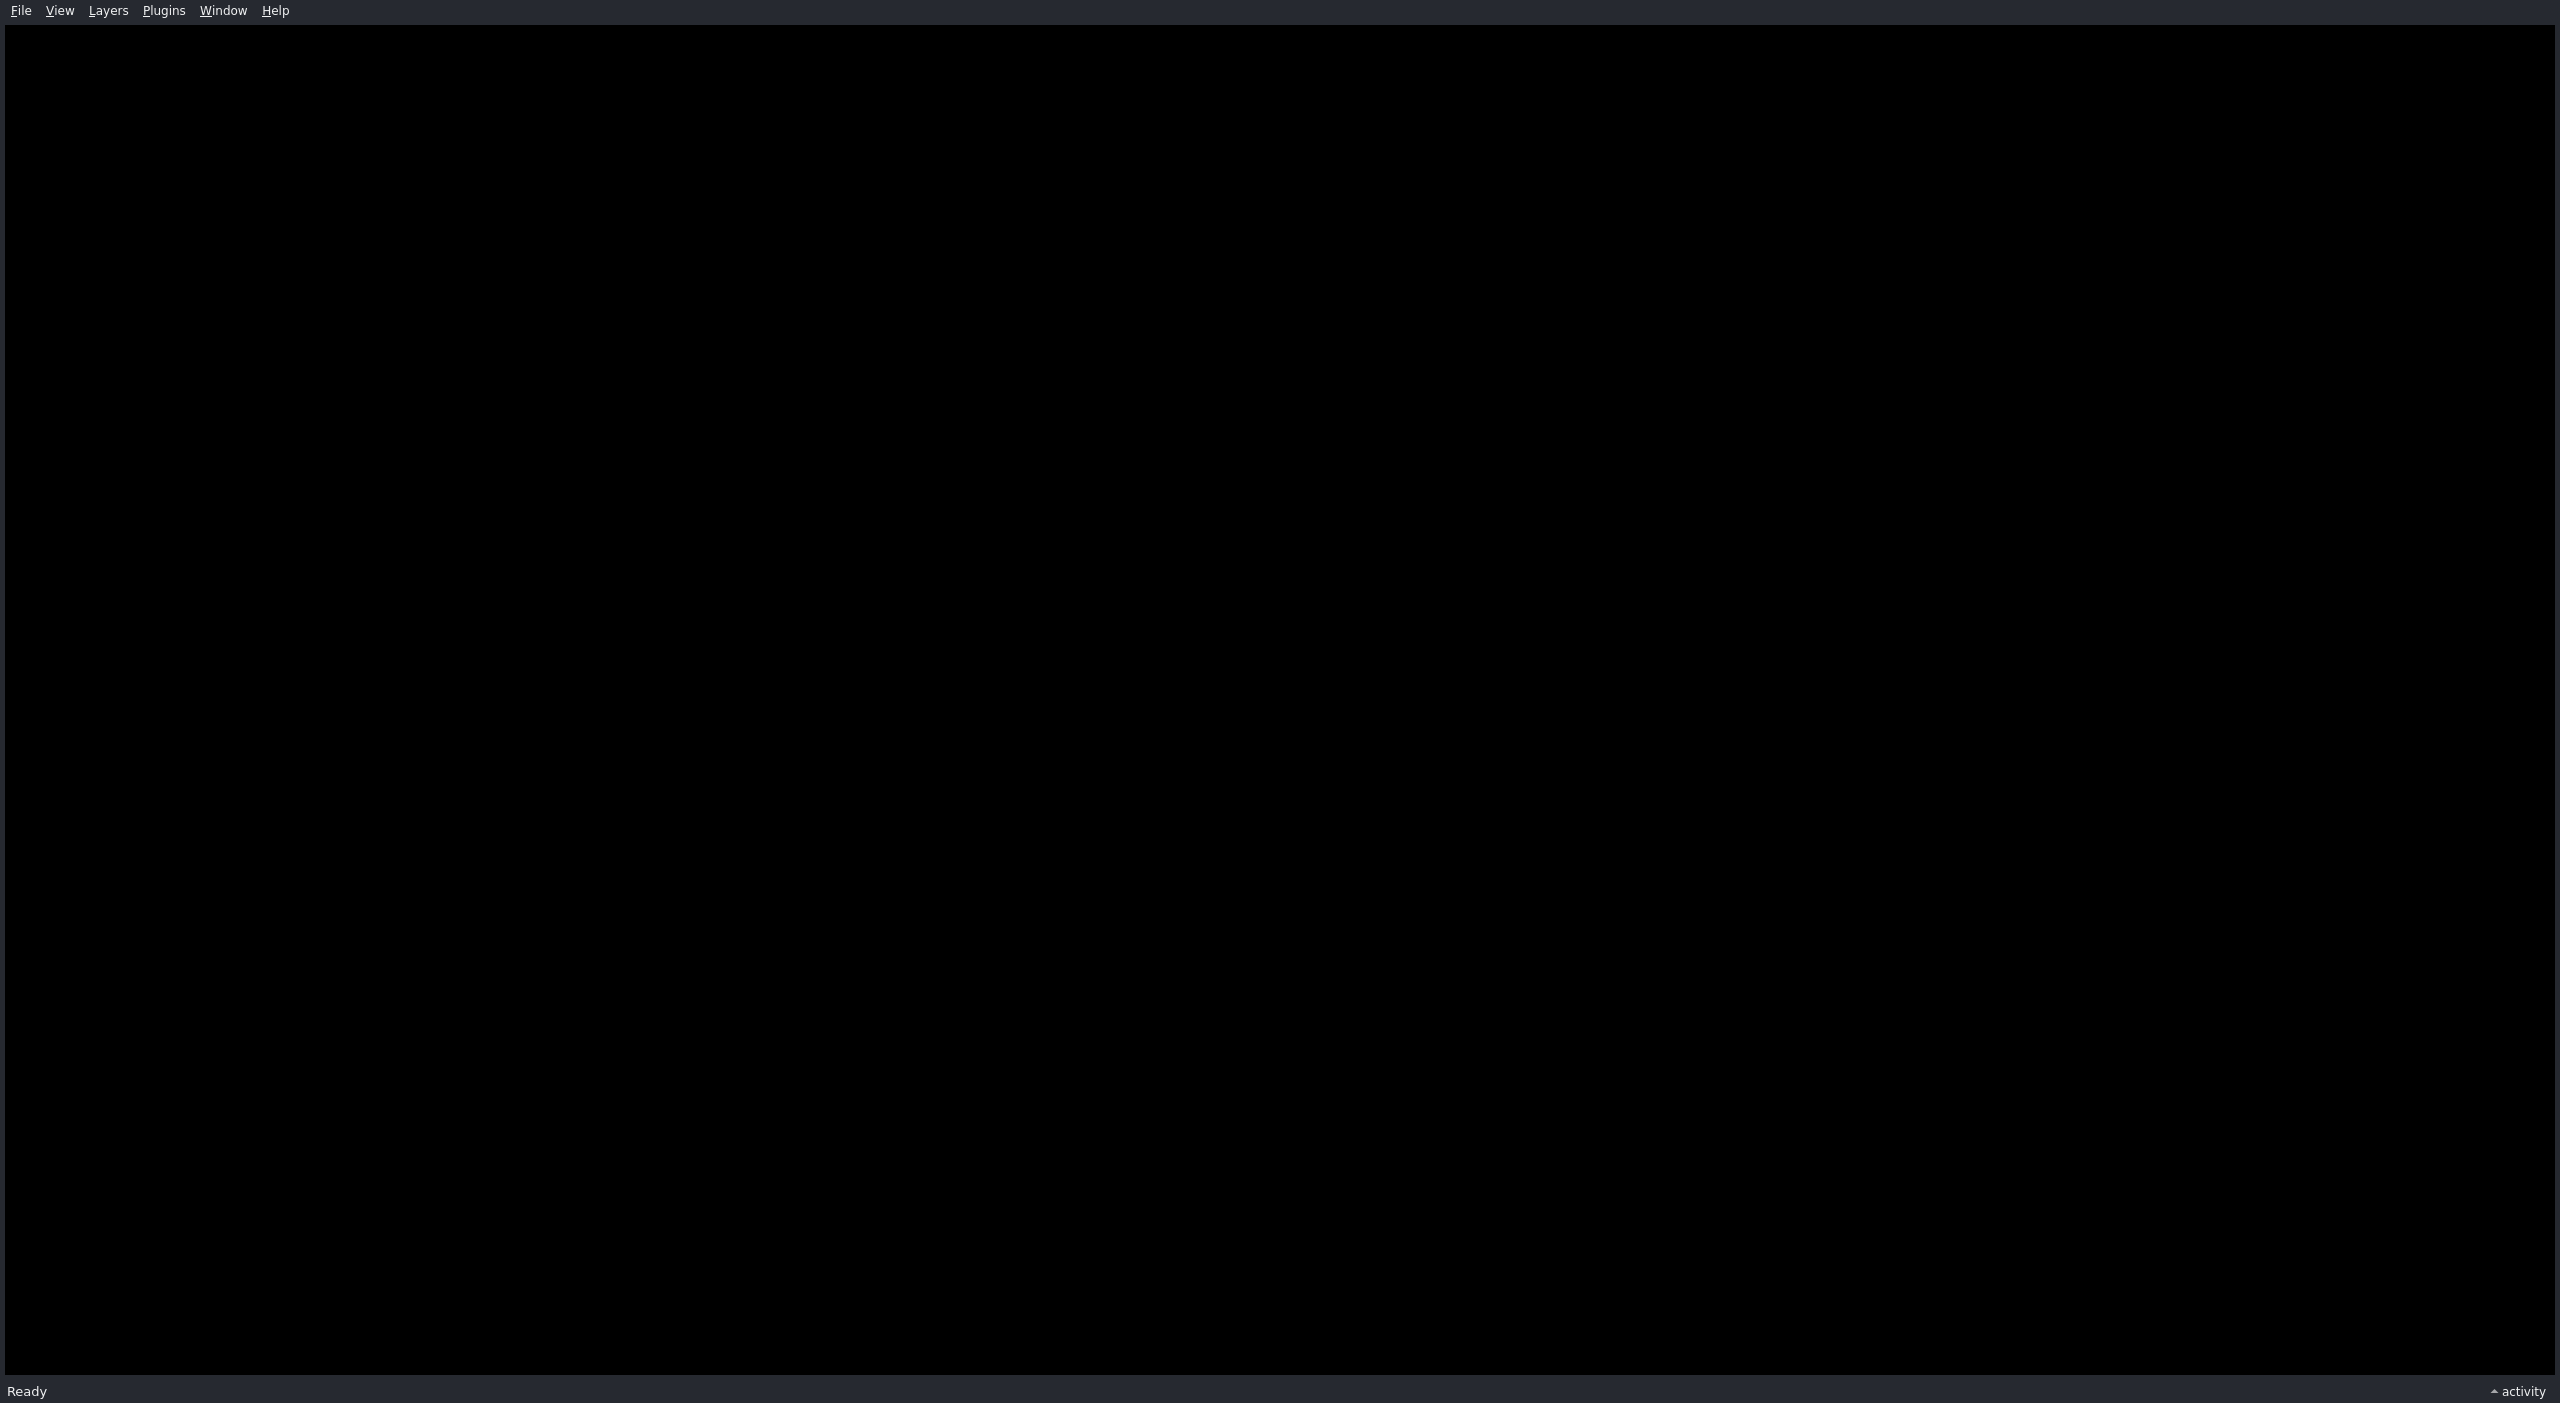

In [12]:
# screenshot the napari viewer
nbscreenshot(viewer)

In [13]:
# close the viewer
viewer.close()
# remove the output ome tiff
pathlib.Path(output_path).unlink()